```{index} single: Pyomo; variables 
```
```{index} single: Pyomo; expressions 
```
```{index} single: Pyomo; objectives 
```
```{index} single: Pyomo; constraints
```
```{index} single: Pyomo; decorators
```
```{index} single: solver; cbc
```

# A basic Pyomo model

Pyomo is an algebraic modeling language for mathematical optimization that is integrated within the Python programming environment. It enables users to create optimization models consisting of decision variables, expressions, objective functions, and constraints. Pyomo provides tools to transform models, and then solve them using a variety of open-source and commercial solvers. As an open-source project, Pyomo is not tied to any specific vendor, solver, or class of mathematical optimization problems, and is constantly evolving through contributions from third-party developers.

This notebook introduces basic elements of Pyomo common to most applications for the small production planning problem introduced earlier in [this notebook](production-planning.ipynb) introduced in a companion notebook:

* [Variables](https://pyomo.readthedocs.io/en/latest/pyomo_modeling_components/Variables.html)
* [Expressions](https://pyomo.readthedocs.io/en/latest/pyomo_modeling_components/Expressions.html)
* [Objectives](https://pyomo.readthedocs.io/en/latest/pyomo_modeling_components/Objectives.html)
* [Constraints](https://pyomo.readthedocs.io/en/latest/pyomo_modeling_components/Constraints.html)
* [SolverFactory](https://pyomo.readthedocs.io/en/stable/solving_pyomo_models.html)

The Pyomo model shown below is a direct translation of the mathematical model into basic Pyomo components. In this approach, parameter values from the mathematical model are included directly in the Pyomo model for simplicity. This method works well for problems with a few decision variables and constraints, but it limits the reuse of the model. Another notebook will demonstrate Pyomo features for writing models for more generic, "data-driven" applications.

This notebook also introduces the use of Python decorators to designate Pyomo expressions, objectives, and constraints. While decorators may be unfamiliar to some Python users, or even current Pyomo users, they offer a significant improvement in the readability of Pyomo model. This feature is relatively new and is available in recent versions of Pyomo.

## Preamble: Install Pyomo and a solver

This collection of notebooks is intended to be run in the cloud on [Google Colab](https://colab.google/) or on a personal computer. To meet this goal, we start each notebook by verifying the installation of Pyomo and an appropriate solver. When run on Google Colab, an installation of Pyomo and a solver must be done for each new Colab session. The [HiGHS solver](https://highs.dev/) is a high performance open source solver for linear and mixed integer optimization on Google Colab.  For a personal computer, we assume Python, Pyomo and the [COIN-OR Cbc solver](https://coin-or.github.io/Cbc/intro.html) ("COIN-OR branch and cut") have been previously installed. Note that there are other suitable solvers, both open-source, such as GLPK, and commercial, such as CPLEX, Gurobi, and Mosek.

The following cell checks if the notebook is running on Google Colab. If so, it does a quiet installation of Pyomo and a solver. A solver is then selected, a test performed to verify that the solver is available, and the solver interface is stored in a global object `SOLVER` for later use.

In [2]:
"""
This cell sets and verifies a global SOLVER for the notebook.

If run on Google Colab, the cell installs Pyomo and HiGHS, then sets SOLVER to use
the Highs solver via the appsi module. If run elsewhere, it assumes Pyomo and CBC
have been previously installed and sets SOLVER to use the CBC solver via the Pyomo 
SolverFactory. For both cases, it then verifies that SOLVER is available.
"""

import sys

if 'google.colab' in sys.modules:
    !pip install pyomo >/dev/null 2>/dev/null
    !pip install highspy >/dev/null 2>/dev/null

    from pyomo.environ import SolverFactory
    SOLVER = SolverFactory('appsi_highs')
    
else:
    from pyomo.environ import SolverFactory
    SOLVER = SolverFactory('cbc')

assert SOLVER.available(), f"Solver {SOLVER} is not available."

## Step 1. Import Pyomo

The first step for a new Pyomo model is to import the needed components into the Python environment. The module `pyomo.environ` provides the components most commonly used for building Pyomo models. This collection of notebooks uses a consistent convention of importing `pyomo.environ` with the `pyo` prefix.

In [3]:
import pyomo.environ as pyo

## Step 2. The `ConcreteModel` object

Pyomo models can be named using any standard Python variable name. In the following code cell, an instance of `ConcreteModel` is created and stored in a Python variable named `model`. It is best to use a short name since it will appear as a prefix for every Pyomo variable and constraint. `ConcreteModel` accepts an optional string argument used to title subsequent reports.

`pyo.ConcreteModel()` is used to create a model object when the problem data is known at the time of construction. Alternatively, pyo.AbstractModel() can create models where the problem data will be provided later to create specific model instances. But this is normally not needed when using the "data-driven" approach demonstrated in this collection of notebooks.


In [4]:
# create model with optional problem title
model = pyo.ConcreteModel("Production Planning: Version 1")

The `.display()` method displays the current content of a Pyomo model. When developing new models, this is a useful tool to verify that the model is being constructed as intended. At this stage, the major components of the model are empty.

In [5]:
# display model
model.display()

Model 'Production Planning: Version 1'

  Variables:
    None

  Objectives:
    None

  Constraints:
    None


## Step 3. Decision variables

Decision variables are created with `pyo.Var()`. Decision variables can be assigned to any valid Python identifier. Here, we assign decision variables to the model instance using the Python 'dot' notation. The variable names are chosen to reflect their names in the mathematical model. 

`pyo.Var()` accepts optional keyword arguments. The most commonly used keyword arguments are:

* `domain` specifies a set of values for a decision variable. By default, the domain is the set of all real numbers. Other commonly used domains are `pyo.NonNegativeReals`, `pyo.NonNegativeIntegers`, and `pyo.Binary`.

* `bounds` is an optional keyword argument to specify a tuple containing values for the lower and upper bounds. It is good modeling practice to specify any known and fixed bounds on the decision variables. `None` can be used as a placeholder if one of the two bounds is unknown. Specifying the bounds as `(0, None)` is equivalent to specifying the domain as `pyo.NonNegativeReals`.

The use of the optional keywords is shown in the following cell. Displaying the model shows that the value of the decision variables is not yet known.

In [6]:
# create decision variables
model.x_M = pyo.Var(bounds=(0, None))
model.x_A = pyo.Var(bounds=(0, 80))
model.x_B = pyo.Var(bounds=(0, 100))

model.y_U = pyo.Var(bounds=(0, 40))
model.y_V = pyo.Var(bounds=(0, None))

# display updated model
model.display()

Model 'Production Planning: Version 1'

  Variables:
    x_M : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 :  None :  None : False :  True :  Reals
    x_A : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 :  None :    80 : False :  True :  Reals
    x_B : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 :  None :   100 : False :  True :  Reals
    y_U : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 :  None :    40 : False :  True :  Reals
    y_V : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 :  None :  None : False :  True :  Reals

  Objectives:
    None

  Constraints:
    None


## Step 4. Expressions

Pyomo expressions are mathematical formulas that involve decision variables. The following cell creates expressions for revenue and cost that are assigned to `model.revenue` and `model.cost`, respectively.

In [7]:
# create expressions
model.revenue = 270 * model.y_U + 210 * model.y_V
model.cost = 10 * model.x_M + 50 * model.x_A + 40 * model.x_B

# expressions can be printed
print(model.revenue)
print(model.cost)

270*y_U + 210*y_V
10*x_M + 50*x_A + 40*x_B


## Step 5. Objective

The objective for this example is to maximize profit which is given by the difference between revenue and cost. There are two ways this objective could be specified in Pyomo.

The first method is to use `pyo.Objective()` where the expression to be optimized is assigned with the `expr` keyword and the type of objective is assigned with the `sense` keyword.

    model.profit = pyo.Objective(expr = model.revenue - model.cost, sense = pyo.maximize)
    
Recent releases of Pyomo provide a second method that uses Python [decorators](https://peps.python.org/pep-0318/) to specify an objective. With a decorator, the same objective is written as

    @model.Objective(sense = pyo.maximize)
    def profit(m):
        return m.revenue - m.cost

Python decorators modify the behavior of the function defined in the next line.  In this case, the decorator `@model.Objective()` modifies the behavior of `profit()` so that it returns an expression for the profit to Pyomo. The keyword `sense` sets the type of objective, which can either be to maximize or minimize the value returned by the objective function. The function `profit()`, after being decorated, takes the Pyomo model as its first argument and adds its name to the model attributes.

In effect, Pyomo decorators are tags that insert functions into a Pyomo model to serve as expressions, objectives, or constraints. Decorators can improve the readability and maintainability of more complex models. They also simplify the syntax for creating other Pyomo objects expressions, constraints, and other optimization-related elements.

In [8]:
@model.Objective(sense=pyo.maximize)
def profit(m):
    return m.revenue - m.cost


model.display()

Model 'Production Planning: Version 1'

  Variables:
    x_M : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 :  None :  None : False :  True :  Reals
    x_A : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 :  None :    80 : False :  True :  Reals
    x_B : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 :  None :   100 : False :  True :  Reals
    y_U : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 :  None :    40 : False :  True :  Reals
    y_V : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 :  None :  None : False :  True :  Reals

  Objectives:
    profit : Size=1, Index=None, Active=True
ERROR: evaluating object as numeric value: y_U
        (object: <class 'pyomo.core.base.var.ScalarVar'>)
    No value for 

## Step 6. Constraints

Constraints are logical relationships between expressions that define the range of feasible solutions in an optimization problem. A constraint consists of two expressions separated by one of the logical relationships. The logical relationships can be equality (`==`), less-than (`<=`), or greater-than (`>=`). 

Constraints can be created with `pyo.Constraint()`. The constraint is passed as a keyword argument `expr` to `pyo.Constraint()`. For this application the constraints could be expressed as  

    model.raw_materials = pyo.Constraint(expr = 10 * model.y_U + 9 * model.y_V <= model.x_M)
    model.labor_A = pyo.Constraint(expr = 1 * model.y_U + 1 * model.y_V <= model.x_A)
    model.labor_B = pyo.Constraint(expr = 2 * model.y_U + 1 * model.y_V <= model.x_B)
    
Alternatively, the `@model.Constraint()` decorator 'tags' the output of the following function as a constraint. For the present example, the constraints are expressed with decorators below. This collection of notebooks uses decorators whenever possible to improve the readability and maintainability of Pyomo models.

In [9]:
@model.Constraint()
def raw_materials(m):
    return 10 * m.y_U + 9 * m.y_V <= m.x_M


@model.Constraint()
def labor_A(m):
    return 1 * m.y_U + 1 * m.y_V <= m.x_A


@model.Constraint()
def labor_B(m):
    return 2 * m.y_U + 1 * m.y_V <= m.x_B


model.pprint()

5 Var Declarations
    x_A : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 :  None :    80 : False :  True :  Reals
    x_B : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 :  None :   100 : False :  True :  Reals
    x_M : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 :  None :  None : False :  True :  Reals
    y_U : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 :  None :    40 : False :  True :  Reals
    y_V : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 :  None :  None : False :  True :  Reals

1 Objective Declarations
    profit : Size=1, Index=None, Active=True
        Key  : Active : Sense    : Expression
        None :   True : maximize : 270*y_U + 210*y_V - (10*x_M + 50*x_A + 40*x_B)

3 Constraint Dec

## Step 7. Solve the model

With the model now fully specified, the next step is to compute a solution. A solver object is created with `SolverFactory` then applied to the model as shown in the following cell. The optional keyword `tee=True` causes the solver to print its output to the output. This can be useful for debugging problems that arise when developing a new model.

In [10]:
results = SOLVER.solve(model, tee=True)

Welcome to the CBC MILP Solver 
Version: 2.10.10 
Build Date: Apr 20 2023 

command line - /opt/homebrew/opt/cbc/bin/cbc -printingOptions all -import /var/folders/zb/k0pc77yj6c3gv6gr6jj41g1r0000gn/T/tmp2_hwem4f.pyomo.lp -stat=1 -solve -solu /var/folders/zb/k0pc77yj6c3gv6gr6jj41g1r0000gn/T/tmp2_hwem4f.pyomo.soln (default strategy 1)
Option for printingOptions changed from normal to all
 CoinLpIO::readLp(): Maximization problem reformulated as minimization
Coin0009I Switching back to maximization to get correct duals etc
Presolve 3 (0) rows, 5 (0) columns and 9 (0) elements
Statistics for presolved model


Problem has 3 rows, 5 columns (5 with objective) and 9 elements
There are 3 singletons with objective 
Column breakdown:
2 of type 0.0->inf, 3 of type 0.0->up, 0 of type lo->inf, 
0 of type lo->up, 0 of type free, 0 of type fixed, 
0 of type -inf->0.0, 0 of type -inf->up, 0 of type 0.0->1.0 
Row breakdown:
2 of type E 0.0, 0 of type E 1.0, 0 of type E -1.0, 
0 of type E other, 0 of typ

## Step 8. Reporting the solution

The final step in most applications is to report the solution in a suitable format. For this example, we demonstrate simple tabular and graphic reports using the Pandas library. For an overview of other ways to report and visualize the solutions, see also the appendix of [this notebook](../04/gasoline-distribution.ipynb) from Chapter 4.

### Pyomo `pprint()`

Pyomo provides several functions for creating model reports that contain solution values. The `pprint()` method can be applied to the entire model, or to individual components of the model, as shown in the following cells.

In [11]:
# display the whole model
model.pprint()

5 Var Declarations
    x_A : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 :  80.0 :    80 : False : False :  Reals
    x_B : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 : 100.0 :   100 : False : False :  Reals
    x_M : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 : 740.0 :  None : False : False :  Reals
    y_U : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 :  20.0 :    40 : False : False :  Reals
    y_V : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 :  60.0 :  None : False : False :  Reals

1 Objective Declarations
    profit : Size=1, Index=None, Active=True
        Key  : Active : Sense    : Expression
        None :   True : maximize : 270*y_U + 210*y_V - (10*x_M + 50*x_A + 40*x_B)

3 Constraint Dec

In [12]:
# display a component of the model
model.profit.pprint()

profit : Size=1, Index=None, Active=True
    Key  : Active : Sense    : Expression
    None :   True : maximize : 270*y_U + 210*y_V - (10*x_M + 50*x_A + 40*x_B)


### Accessing solution values with `pyo.value()`

After a solution to a Pyomo model has been successfully computed, values for the objective, expressions, and decisions variables can be accessed with `pyo.value()`.

In [13]:
pyo.value(model.profit)

2600.0

When combined with [Python f strings](https://docs.python.org/3/tutorial/inputoutput.html), `pyo.value()` provides a convenient means of creating formatted reports.

In [14]:
print(f" Profit = {pyo.value(model.profit): 9.2f}")
print(f"Revenue = {pyo.value(model.revenue): 9.2f}")
print(f"   Cost = {pyo.value(model.cost): 9.2f}")

 Profit =   2600.00
Revenue =  18000.00
   Cost =  15400.00


Pyomo provides a shortcut notation for accessing solution. After a solution has been computed, a function with the same name as decision variable is created that will report the solution value. 

In [15]:
print("x_A =", model.x_A())
print("x_B =", model.x_B())
print("x_M =", model.x_M())

x_A = 80.0
x_B = 100.0
x_M = 740.0


### Creating reports with Pandas

Pandas is an open-source library for working with data in Python and is widely used in the data science community. Here we use a Pandas `Series()` object to hold and display solution data. We can then visualize them using the Matplotlib library, for instance with a bar chart.

In [31]:
import pandas as pd

# create pandas series for production and raw materials
production = pd.Series(
    {
        "U": pyo.value(model.y_U),
        "V": pyo.value(model.y_V),
    }
)

raw_materials = pd.Series(
    {
        "A": pyo.value(model.x_A),
        "B": pyo.value(model.x_B),
        "M": pyo.value(model.x_M),
    }
)

# display pandas series
display(production)
display(raw_materials)

U    20.0
V    60.0
dtype: float64

A     80.0
B    100.0
M    740.0
dtype: float64

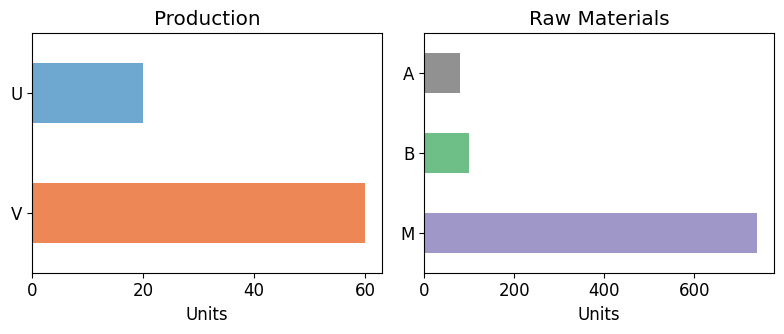

In [47]:
import matplotlib.pyplot as plt

# Create a 1x2 grid of subplots and configure global settings
fig, ax = plt.subplots(1, 2, figsize=(8, 3.5))
plt.rcParams["font.size"] = 12
colors = plt.cm.tab20c.colors
color_sets = [[colors[0], colors[4]], [colors[16], colors[8], colors[12]]]
datasets = [production, raw_materials]
titles = ["Production", "Raw Materials"]

# Plot data on subplots
for i, (data, title, color_set) in enumerate(zip(datasets, titles, color_sets)):
    data.plot(ax=ax[i], kind="barh", title=title, alpha=0.7, color=color_set)
    ax[i].set_xlabel("Units")
    ax[i].invert_yaxis()
plt.tight_layout()
plt.show()

To discover more advanced Pyomo features, see the [next notebook](production-planning-advanced.ipynb).